# Question 2 : Question 2: Comparing Feedforward NN vs. Neural ODEs.

# Part A: Standard Fully Connected Neural Network

Standard NN on Moons Dataset

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Generate toy dataset
X, y = make_moons(n_samples=1000, noise=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Normalize input features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# Simple Feedforward NN
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

model = SimpleNN()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Train model
epochs = 100
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_train_tensor)
    loss = criterion(output, y_train_tensor)
    loss.backward()
    optimizer.step()
    
    if epoch % 20 == 0:
        with torch.no_grad():
            train_acc = ((output > 0.5) == y_train_tensor).float().mean()
            test_pred = model(X_test_tensor)
            test_acc = ((test_pred > 0.5) == y_test_tensor).float().mean()
            print(f"Epoch {epoch}: Loss={loss.item():.4f}, Train Acc={train_acc:.4f}, Test Acc={test_acc:.4f}")

# Final accuracy
with torch.no_grad():
    final_train_acc = ((model(X_train_tensor) > 0.5) == y_train_tensor).float().mean()
    final_test_acc = ((model(X_test_tensor) > 0.5) == y_test_tensor).float().mean()

print(f"\nFinal Train Accuracy: {final_train_acc:.4f}")
print(f"Final Test Accuracy: {final_test_acc:.4f}")


Epoch 0: Loss=0.6673, Train Acc=0.6657, Test Acc=0.8567
Epoch 20: Loss=0.3050, Train Acc=0.8543, Test Acc=0.8700
Epoch 40: Loss=0.2815, Train Acc=0.8757, Test Acc=0.8900
Epoch 60: Loss=0.2620, Train Acc=0.8843, Test Acc=0.9033
Epoch 80: Loss=0.2382, Train Acc=0.8971, Test Acc=0.9233

Final Train Accuracy: 0.9186
Final Test Accuracy: 0.9300


<b> Decision Boundary Plot

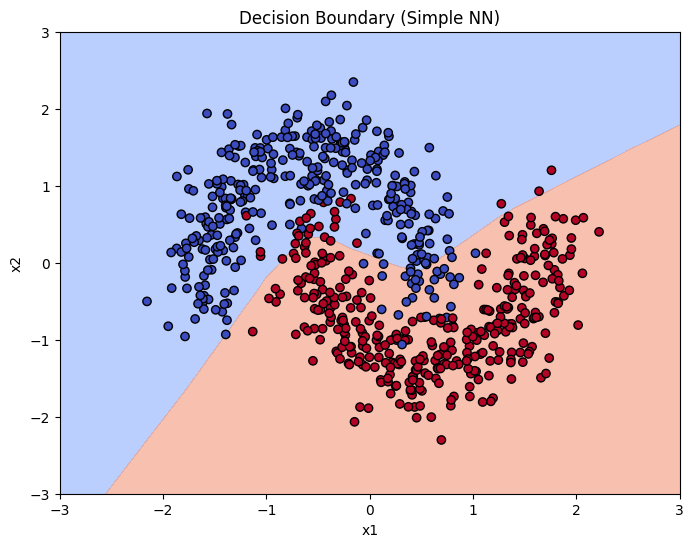

In [4]:
import numpy as np

# Create grid
xx, yy = np.meshgrid(np.linspace(-3, 3, 300), np.linspace(-3, 3, 300))
grid = np.c_[xx.ravel(), yy.ravel()]
grid_scaled = torch.tensor(grid, dtype=torch.float32)

# Predict
with torch.no_grad():
    Z = model(grid_scaled).reshape(xx.shape)

# Plot
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, levels=[0, 0.5, 1], cmap="coolwarm", alpha=0.6)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap="coolwarm", edgecolors='k')
plt.title("Decision Boundary (Simple NN)")
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()


# Part B: Neural ODE for Classification on Moons Dataset

In [5]:
! pip install torchdiffeq


     -------------------------------------- 216.0/216.0 MB 1.6 MB/s eta 0:00:00
     ---------------------------------------- 46.2/46.2 MB 4.7 MB/s eta 0:00:00
     ---------------------------------------- 15.9/15.9 MB 6.1 MB/s eta 0:00:00
  Using cached jinja2-3.1.6-py3-none-any.whl (134 kB)
  Using cached sympy-1.14.0-py3-none-any.whl (6.3 MB)
     ------------------------------------- 199.1/199.1 KB 11.8 MB/s eta 0:00:00
  Using cached filelock-3.18.0-py3-none-any.whl (16 kB)
     ---------------------------------------- 1.6/1.6 MB 5.0 MB/s eta 0:00:00
     ---------------------------------------- 43.8/43.8 KB 2.1 MB/s eta 0:00:00
  Using cached mpmath-1.3.0-py3-none-any.whl (536 kB)


You should consider upgrading via the 'C:\Users\SHIVAM VYAS\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Dataset (same as before)
X, y = make_moons(n_samples=1000, noise=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# Define ODE function f(h, t)
class ODEFunc(nn.Module):
    def __init__(self, hidden_dim=32):
        super(ODEFunc, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(hidden_dim, 16),
            nn.ReLU(),
            nn.Linear(16, hidden_dim),
        )

    def forward(self, t, h):
        return self.net(h)

# Neural ODE Block
class NeuralODEBlock(nn.Module):
    def __init__(self, hidden_dim=32, solver='rk4', t_span=torch.tensor([0., 1.])):
        super(NeuralODEBlock, self).__init__()
        self.func = ODEFunc(hidden_dim)
        self.solver = solver
        self.integration_time = t_span

    def forward(self, h0):
        # odeint expects shape (batch, features), but solves over time dim
        # integration_time shape: (T,) - timespan to integrate over
        out = odeint(self.func, h0, self.integration_time, method=self.solver)
        # out shape: (time_steps, batch, features)
        # We want the final time point output
        return out[-1]

# Full Neural ODE Model
class NeuralODEModel(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=32):
        super(NeuralODEModel, self).__init__()
        self.input_layer = nn.Linear(input_dim, hidden_dim)
        self.ode_block = NeuralODEBlock(hidden_dim)
        self.output_layer = nn.Sequential(
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        h0 = self.input_layer(x)
        hT = self.ode_block(h0)
        out = self.output_layer(hT)
        return out

# Instantiate model, loss, optimizer
model_ode = NeuralODEModel()
criterion = nn.BCELoss()
optimizer = optim.Adam(model_ode.parameters(), lr=0.01)

# Train loop
epochs = 100
for epoch in range(epochs):
    model_ode.train()
    optimizer.zero_grad()
    output = model_ode(X_train_tensor)
    loss = criterion(output, y_train_tensor)
    loss.backward()
    optimizer.step()

    if epoch % 20 == 0:
        with torch.no_grad():
            train_acc = ((output > 0.5) == y_train_tensor).float().mean()
            test_pred = model_ode(X_test_tensor)
            test_acc = ((test_pred > 0.5) == y_test_tensor).float().mean()
            print(f"Epoch {epoch}: Loss={loss.item():.4f}, Train Acc={train_acc:.4f}, Test Acc={test_acc:.4f}")

# Final accuracy
with torch.no_grad():
    final_train_acc = ((model_ode(X_train_tensor) > 0.5) == y_train_tensor).float().mean()
    final_test_acc = ((model_ode(X_test_tensor) > 0.5) == y_test_tensor).float().mean()

print(f"\nNeural ODE Final Train Accuracy: {final_train_acc:.4f}")
print(f"Neural ODE Final Test Accuracy: {final_test_acc:.4f}")


ModuleNotFoundError: No module named 'torchdiffeq'

<b> Plot decision boundary for Neural ODE model

In [ ]:
import numpy as np

xx, yy = np.meshgrid(np.linspace(-3, 3, 300), np.linspace(-3, 3, 300))
grid = np.c_[xx.ravel(), yy.ravel()]
grid_scaled = scaler.transform(grid)
grid_scaled_torch = torch.tensor(grid_scaled, dtype=torch.float32)

with torch.no_grad():
    Z = model_ode(grid_scaled_torch).reshape(xx.shape)

plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, levels=[0, 0.5, 1], cmap="coolwarm", alpha=0.6)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap="coolwarm", edgecolors='k')
plt.title("Decision Boundary (Neural ODE Model)")
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()


In [10]:

model.eval()
with torch.no_grad():
    train_preds = model(X_train_tensor).argmax(dim=1)
    final_train_acc_baseline = (train_preds == y_train_tensor).float().mean().item()

    test_preds = model(X_test_tensor).argmax(dim=1)
    final_test_acc_baseline = (test_preds == y_test_tensor).float().mean().item()

# Similarly for Neural ODE model:
model_ode.eval()
with torch.no_grad():
    train_preds_ode = model_ode(X_train_tensor).argmax(dim=1)
    final_train_acc_ode = (train_preds_ode == y_train_tensor).float().mean().item()

    test_preds_ode = model_ode(X_test_tensor).argmax(dim=1)
    final_test_acc_ode = (test_preds_ode == y_test_tensor).float().mean().item()

NameError: name 'model_ode' is not defined

# Part C (a) Compare performance (accuracy and loss) of both models

In [9]:
print(f"Baseline NN Train Accuracy: {final_train_acc_baseline:.4f}")
print(f"Baseline NN Test Accuracy:  {final_test_acc_baseline:.4f}")
print(f"Neural ODE Train Accuracy:  {final_train_acc_ode:.4f}")
print(f"Neural ODE Test Accuracy:   {final_test_acc_ode:.4f}")


NameError: name 'final_train_acc_baseline' is not defined